In [132]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import glob 

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [155]:
data_batches = glob.glob('cifar-10-batches-py/data_batch_*')
data, labels = [], []
for batch in data_batches:
    data.append(unpickle(batch)[b'data'])
    labels.append(unpickle(batch)[b'labels'])
    
X_full = np.concatenate(data, axis=0)
y_full = np.concatenate(labels, axis=0)
X_test = unpickle('cifar-10-batches-py/test_batch')[b'data']
y_test = unpickle('cifar-10-batches-py/test_batch')[b'labels']

In [163]:
def construct_img(arr):
    return np.stack(np.split(arr, 3), axis=-1).reshape((32, 32, 3))

img_0 = construct_img(X_full[0])
img_1 = construct_img(X_full[1])
img_2 = construct_img(X_full[2])

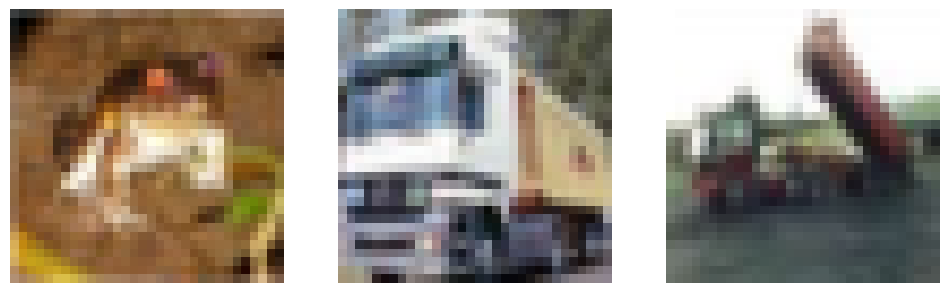

In [164]:
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(img_0)
ax[1].imshow(img_1)
ax[2].imshow(img_2)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()